In [25]:
#Bidirectional LSTM
#DENSE OUTPUT LAYER

#Based on https://github.com/maetshju/gsoc2018/blob/master/speech-blstm/01-speech-blstm.jl
#and https://github.com/denizyuret/Knet.jl/blob/master/tutorial/60.rnn.ipynb

In [26]:
#Input Features = 13

#Emotions to train on
#01 (Neutral) and 03 (Happy)

In [27]:
using BSON


ENV["COLUMNS"] = 72
using Pkg; for p in ("Knet","IterTools","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Random: shuffle!
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Knet: Knet, AutoGrad, gpu, param, param0, mat, RNN, relu, Data, adam, progress, nll, zeroone

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.4/Pkg/src/Pkg.jl:531
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.4/Pkg/src/Pkg.jl:531
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.4/Pkg/src/Pkg.jl:531


In [28]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)


In [29]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; end
Dense(i::Int,o::Int,f=identity) = Dense(param(o,i), param0(o), f)
(d::Dense)(x) = d.f.(d.w * mat(x,dims=1) .+ d.b)

In [30]:
#Rule
include_1_3(x) = occursin(r"03-01-(?:01|03)-0[1-2]-0[1-2]-0[1-2]-[0-9][0-9].bson",x)



include_1_3 (generic function with 1 method)

In [70]:
#Relabling rule
function encode_1_3(Y)

ARRAY = Array{Float32}
Ÿ = ARRAY(mat(Y))
    
m=ARRAY(zeros(2,length(y)));
    
    for i in 1:length(Ÿ)
        m[ (Ÿ[i]==1 ? 1 : 3) ,i]=1; 
    end
    
return m

end

encode_1_3 (generic function with 1 method)

In [71]:
"""
    readData(dataDir)
Reads in the data contained in a specified directory
    
# Parameters
* **dataDir** String of the path to the directory containing the data
#LOAD BSON

# Return
* **Xs** Vector where each element is a vector of the frames for
one utterance
* **Ys** A vector where each element is a vector of the labels for
the frames for one utterance
"""

function readData(dataDir, rule)
    fnames = readdir(dataDir)

    Xs = Vector()
    Ys = Vector()
    
    for (i, fname) in enumerate(fnames)
        print(string(i) * "/" * string(length(fnames)) * "\r")
        #print(fname)
        if rule(fname) 
            BSON.@load joinpath(dataDir, fname) x y
            
            #println(summary(x));
            #x = [x[i,:] for i in 1:size(x,1)]
            #println(summary(x));
            #y = [y[i,:] for i in 1:size(y,1)]
            push!(Xs, x)
            #vcat(Xs, x)
            push!(Ys, y)
            #vcat(Ys, y)
            #println(y)
            #break
            #println(y)
            #return
        end
    end
    
    #EXPLICIT TYPING!!!
    return (Array{Float32,2}.(Xs), (Ys))
end


readData (generic function with 1 method)

In [72]:
(Xs, Ys) =  readData("Datasets/ravdess-26-features", include_1_3);

In [73]:
AllXs = (vcat(Xs...))
AllYs = (vcat(Ys...));

In [74]:
#MASH SAMPLES TOGETHER TO FORM A SUPERMASSIVE ARRAY!!!
#AllXs

#reshape(AllXs[1:100,:],13,20,5)


In [101]:
BATCHSIZE = 16
SEQLENGTH = 8;

#Since there is no embedding, you can just treat the features like the X dimension!

function seqbatch(x,y,F,B,T)
    
    #X IS ALREADY 2D DON'T DIVIDE BY LENGTH
    #N = length(x) ÷ B
    N = size(AllXs)[1] ÷ B
    println(N)
    println(B)
    println(T)
    
    x = (reshape(x[1:N*B,:],F,N,B))
    println(summary(x))
    
    y = (reshape(y[1:N*B,:],1,N,B))
    println(summary(y))
    
    d = []; for i in 0:T:N-T
        push!(d, (x[:,i+1:i+T,:], y[:,i+1:i+T,:]))
    end
    return d
end


function seqbatchTest(x,y,B,T)
    
    #X IS ALREADY 2D DON'T DIVIDE BY LENGTH
    #N = length(x) ÷ B
    println(size(AllXs)[1])
    N = size(AllXs)[1] ÷ B
    println(N)
    println(B)
    println(T)
    
    println(summary(y))
    y = (reshape(y[:,1:N*B,:],1,N,B))
    println(summary(y))
    
    #ONEHOT ENCODE
end




seqbatchTest (generic function with 1 method)

In [102]:
FEATURES = 26
HIDDENSIZE = 32
OUTPUTSIZE = 2;

In [103]:
d = seqbatch(AllXs, AllYs, FEATURES, BATCHSIZE, SEQLENGTH);
#d = seqbatchTest(AllXs, AllYs,  BATCHSIZE, SEQLENGTH);
#Target 2x64x32

6453
16
8
26×6453×16 Array{Float32,3}
1×6453×16 Array{UInt8,3}


In [104]:
#summary(d[1][2])


In [105]:
#display(permutedims(Xs))

In [106]:
#mat(Xs[1])

In [107]:
# shuffle and split minibatches into train and test portions
shuffle!(d)
dtst = d[1:10]
dtrn = d[11:end];

In [108]:
#size(dtrn[1],1)
length.((dtrn,dtst))

(796, 10)

In [109]:
function trainresults(file,maker,savemodel)
    if (print("Train from scratch? "); readline()[1]=='y')
        model = maker()
        results = ((nll(model,dtst), zeroone(model,dtst))
                   for x in takenth(progress(adam(model,ncycle(dtrn,5))),100))
        results = reshape(collect(Float32,flatten(results)),(2,:))
        Knet.save(file,"model",(savemodel ? model : nothing),"results",results)
        Knet.gc() # To save gpu memory
    else
        println("¯\\_(ツ)_/¯")
    end
    println(minimum(results,dims=2))
    return model,results
end

trainresults (generic function with 1 method)

In [110]:

BIRNN(input,hidden,output)=  # biRNN 
Chain(RNN(input,hidden,rnnType=:relu,bidirectional=true,dataType=Float32),Dense(2hidden,output));

In [113]:
HIDDENSIZE = 60

EMREC() = BIRNN(FEATURES,HIDDENSIZE,OUTPUTSIZE)
(tEm,rEm) = trainresults("emrec-26-16-16.jld2",EMREC,true);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 3980/3980, 00:20/00:20, 195.05i/s] 


Float32[0.5954611; 0.2703125]


In [114]:
using Plots; default(fmt=:png,ls=:auto,ymirror=true)

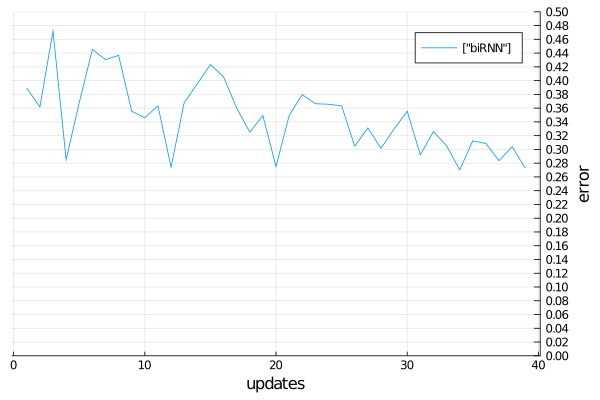

In [115]:
plot([rEm[2,:]]; xlabel="updates", ylabel="error",
    ylim=(0,0.5), yticks=0:0.02:0.5, labels=["biRNN"])

In [155]:
function tag(tagger,k,L)
    #samples = s
    #println(samples)
    labels = emotions[(x->x[1]).(argmax(Array(tEm(reshape(Xs[k],26,1,L))),dims=1))]
    #vcat(samples,labels)
    labels
end

tag (generic function with 2 methods)

In [156]:
tag(EMREC,1,328)

BoundsError: BoundsError: attempt to access 1-element Array{String,1} at index [[1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]

In [149]:
emotions = ["neutral,happy"]

1-element Array{String,1}:
 "happy,neutral"

In [143]:
reshape(Xs[1],26,1,328)

26×1×328 Array{Float32,3}:
[:, :, 1] =
 -158.44759
 -504.6143
 -167.6936
 -136.85472
 -145.15147
 -125.939644
 -144.97498
 -128.19456
 -123.62134
 -128.04933
 -121.64569
 -131.79652
 -144.95607
 -132.5605
 -131.79839
 -120.24388
 -114.45146
 -132.20493
 -146.28842
 -133.9444
 -121.4317
 -122.54968
 -135.39066
 -120.81583
 -125.24479
 -148.99736

[:, :, 2] =
 -152.01717
 -129.17183
 -128.77753
 -123.08497
 -118.05649
 -129.42528
 -144.80547
 -158.45955
 -133.35197
 -138.40515
 -127.94004
 -129.50296
 -163.9895
 -133.83154
 -147.7202
 -155.95316
 -131.39186
 -139.14969
 -504.6143
 -136.34299
 -141.58849
 -134.33522
 -150.74562
 -504.6143
 -144.35312
 -137.95537

[:, :, 3] =
 -135.96745
 -135.85068
 -134.13023
 -138.34065
 -141.93942
 -122.505226
 -124.69218
 -135.82951
 -138.99739
 -504.6143
 -140.20514
 -132.4192
 -138.37752
 -136.61874
 -167.43106
 -126.84669
 -114.310646
 -131.92824
 -129.47511
 -128.79141
 -123.33966
 -109.99274
 -109.62951
 -107.56798
 -105.977325
 -112.71718

...

